# Term Deposit Prediction

### Import Libraries

In [ ]:
# !pip install pywaffle  
### If you are using Google Colab

In [1]:
import warnings

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from plotly.offline import init_notebook_mode
from pywaffle import Waffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    fbeta_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

init_notebook_mode(connected=True)

warnings.filterwarnings(action="ignore")


class Colors:
    Gray = "#5d5d5d"
    LightGray = "#fafafa"
    Black = "#000000"
    White = "#FFFFFF"
    Teal = "#008080"
    Aquamarine = "#76c8c8"
    Blue = "#2596be"
    LightCyan = "#badbdb"
    WhiteSmoke = "#dedad2"
    Cream = "#e4bcad"
    PeachPuff = "#df979e"
    HotPink = "#d7658b"
    DeepPink = "#c80064"
    LightSeaGreen = "#20B2AA"
    DarkGray = "#464144"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 55.5 MB/s eta 0:00:00


### Import Data

In [2]:
def read_banking_data(filepath) -> pd.DataFrame:
    data = pd.read_csv(filepath, delimiter=";").rename(columns={"y": "subscribed"})
    data = data[data["age"] != "age"]
    numeric = ["age", "balance", "duration", "day", "campaign", "pdays", "previous"]
    for att in numeric:
        data[att] = pd.to_numeric(data[att])

    return data

df = read_banking_data("./train.csv")
df.head()


age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome subscribed  
0  unknown    5   may       261         1     -1         0  unknown         no  
1  unknown    5   may       151         1     -1         0  unknown         no  
2  unknown    5   may        76         1     -1         0  unknown         no  
3  unknown    5   may        92         1     -1         0  unknown         no  
4  unknown    5   may       198         1     -1         0  unknown         no

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         45211 non-null  int64 
 1   job         45211 non-null  object
 2   marital     45211 non-null  object
 3   education   45211 non-null  object
 4   default     45211 non-null  object
 5   balance     45211 non-null  int64 
 6   housing     45211 non-null  object
 7   loan        45211 non-null  object
 8   contact     45211 non-null  object
 9   day         45211 non-null  int64 
 10  month       45211 non-null  object
 11  duration    45211 non-null  int64 
 12  campaign    45211 non-null  int64 
 13  pdays       45211 non-null  int64 
 14  previous    45211 non-null  int64 
 15  poutcome    45211 non-null  object
 16  subscribed  45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.2+ MB


## Analysis

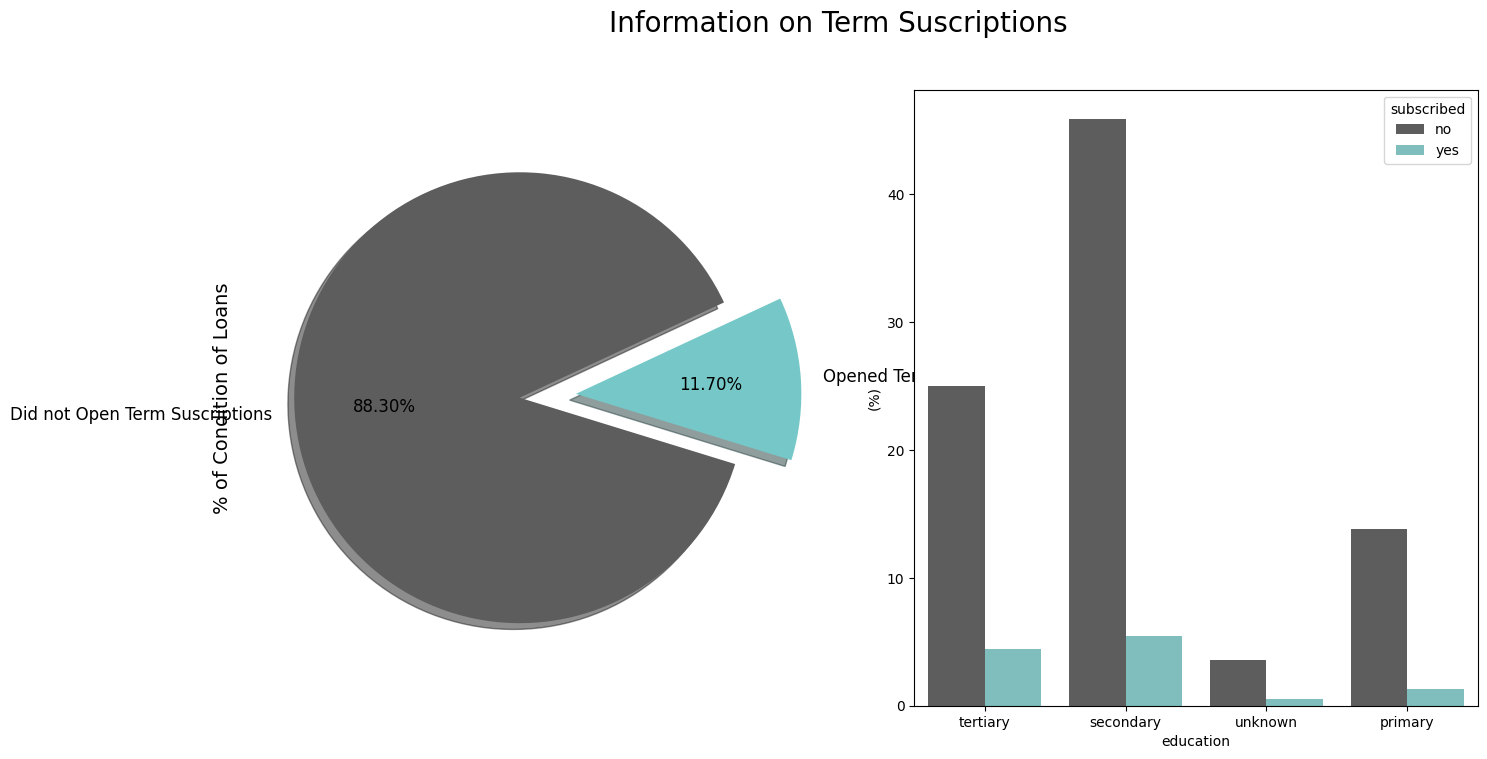

In [4]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
colors = ["#5d5d5d", "#76c8c8"]
labels = "Did not Open Term Suscriptions", "Opened Term Suscriptions"

plt.suptitle("Information on Term Suscriptions", fontsize=20)
df["subscribed"].value_counts().plot.pie(
    explode=[0, 0.25],
    autopct="%1.2f%%",
    ax=ax[0],
    shadow=True,
    colors=colors,
    labels=labels,
    fontsize=12,
    startangle=25,
)


ax[0].set_ylabel("% of Condition of Loans", fontsize=14)
palette = ["#5d5d5d", "#76c8c8"]
sns.barplot(
    x="education",
    y="balance",
    hue="subscribed",
    data=df,
    palette=palette,
    estimator=lambda x: len(x) / len(df) * 100,
)
ax[1].set(ylabel="(%)")
ax[1].set_xticklabels(df["education"].unique(), rotation=0, rotation_mode="anchor")
plt.show()


### Distribution of Numeric Data

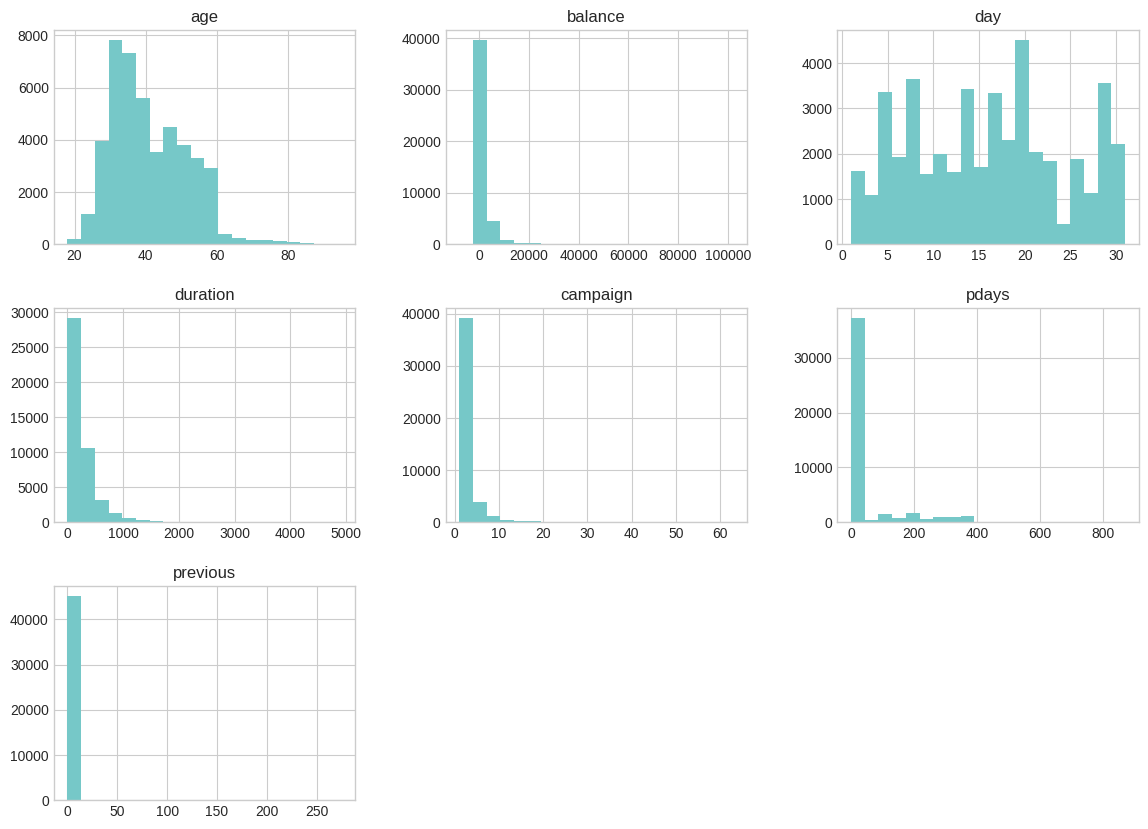

In [5]:
plt.style.use("seaborn-whitegrid")

df.hist(bins=20, figsize=(14, 10), color="#76c8c8")
plt.show()


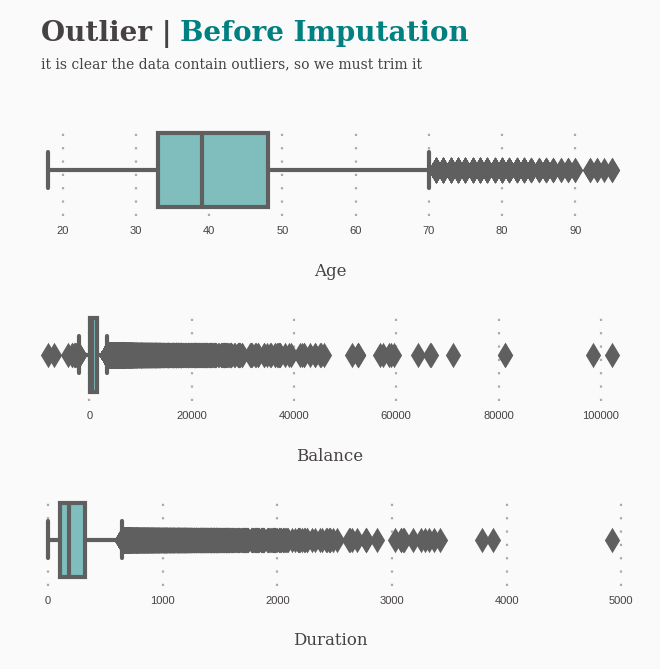

In [6]:
fig = plt.figure(figsize=(4, 3), dpi=200, facecolor=Colors.LightGray)
gs = fig.add_gridspec(3, 1, hspace=1)

for ax in range(0, 3):
    locals()["axis" + str(ax)] = fig.add_subplot(gs[ax, 0])
    locals()["axis" + str(ax)].grid(
        which="major",
        axis="x",
        zorder=0,
        color="gray",
        linestyle=":",
        dashes=(1, 5),
        alpha=0.65,
    )
    locals()["axis" + str(ax)].set_facecolor(Colors.LightGray)
    locals()["axis" + str(ax)].tick_params(axis="y", left=False)
    locals()["axis" + str(ax)].tick_params(
        axis="x", labelsize=4, bottom=False, labelcolor=Colors.DarkGray
    )
    locals()["axis" + str(ax)].xaxis.set_label_coords(0, -0.5)

    spines = ["top", "left", "right", "bottom"]
    for sp in spines:
        locals()["axis" + str(ax)].spines[sp].set_visible(False)

for ax, col in zip(range(0, 3), ["age", "balance", "duration"]):
    sns.boxplot(data=df, x=col, ax=locals()["axis" + str(ax)], color=Colors.Aquamarine)
    locals()["axis" + str(ax)].set_xlabel(
        col.title(), fontfamily="serif", fontsize=6, color=Colors.DarkGray
    )

axis0.text(
    17,
    -1.4,
    "Outlier |",
    fontweight="bold",
    fontfamily="serif",
    fontsize=10,
    color=Colors.DarkGray,
)
axis0.text(
    36,
    -1.4,
    "Before Imputation",
    fontweight="bold",
    fontfamily="serif",
    fontsize=10,
    color=Colors.Teal,
)
axis0.text(
    17,
    -1.1,
    "it is clear the data contain outliers, so we must trim it",
    fontweight="normal",
    fontfamily="serif",
    fontsize=5,
    color=Colors.DarkGray,
)

fig.show()


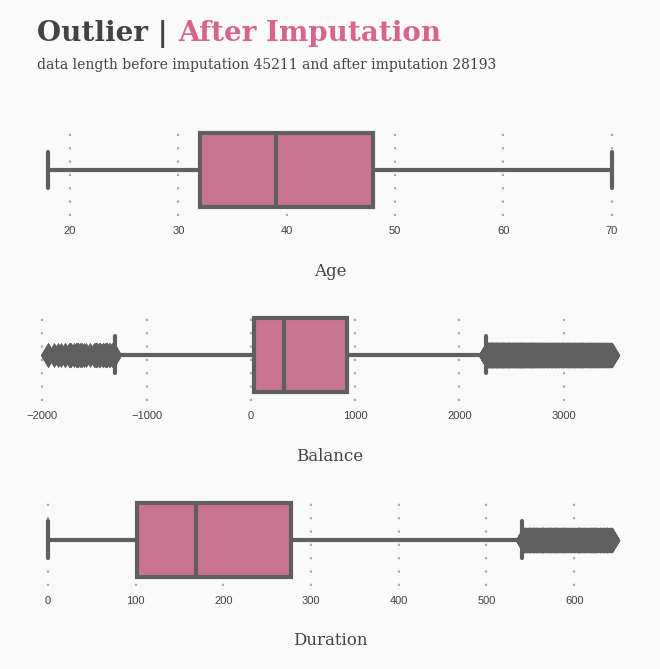

In [7]:
def handling_outlier() -> pd.DataFrame:
    cols = [
        "age",
        "balance",
        "duration",
        "day",
        "duration",
        "campaign",
        "pdays",
        "previous",
    ]
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    df2 = df[
        ~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)
    ]
    return df2


df2 = handling_outlier()

fig = plt.figure(figsize=(4, 3), dpi=200, facecolor=Colors.LightGray)
gs = fig.add_gridspec(3, 1, hspace=1)

for ax in range(0, 3):
    locals()["axis" + str(ax)] = fig.add_subplot(gs[ax, 0])
    locals()["axis" + str(ax)].grid(
        which="major",
        axis="x",
        zorder=0,
        color="gray",
        linestyle=":",
        dashes=(1, 5),
        alpha=0.65,
    )
    locals()["axis" + str(ax)].set_facecolor(Colors.LightGray)
    locals()["axis" + str(ax)].tick_params(axis="y", left=False)
    locals()["axis" + str(ax)].tick_params(
        axis="x", labelsize=4, bottom=False, labelcolor=Colors.DarkGray
    )
    locals()["axis" + str(ax)].xaxis.set_label_coords(0, -0.5)

    spines = ["top", "left", "right", "bottom"]
    for sp in spines:
        locals()["axis" + str(ax)].spines[sp].set_visible(False)

for ax, col in zip(range(0, 3), ["age", "balance", "duration"]):
    sns.boxplot(data=df2, x=col, ax=locals()["axis" + str(ax)], color=Colors.HotPink)
    locals()["axis" + str(ax)].set_xlabel(
        col.title(), fontfamily="serif", fontsize=6, color=Colors.DarkGray
    )

axis0.text(
    17,
    -1.4,
    "Outlier |",
    fontweight="bold",
    fontfamily="serif",
    fontsize=10,
    color=Colors.DarkGray,
)
axis0.text(
    30,
    -1.4,
    "After Imputation",
    fontweight="bold",
    fontfamily="serif",
    fontsize=10,
    color=Colors.HotPink,
)
axis0.text(
    17,
    -1.1,
    f"data length before imputation {len(df)} and after imputation {len(df2)}",
    fontweight="normal",
    fontfamily="serif",
    fontsize=5,
    color=Colors.DarkGray,
)

fig.show()


### Data Preparation

In [8]:
def data_prep(*var_name, dataframe) -> pd.DataFrame:
    data = dataframe.groupby([*var_name]).size().to_frame(name="count").reset_index()
    data["percentage"] = data["count"].apply(lambda x: x / sum(data["count"]) * 100)

    return data


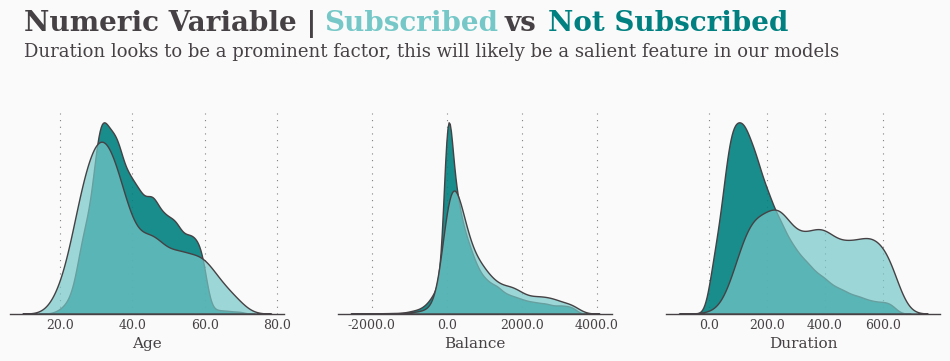

In [9]:
no_subs = df2.query("subscribed == 'no'")
yes_subs = df2.query("subscribed == 'yes'")

fig = plt.figure(figsize=(12, 12), dpi=100, facecolor=Colors.LightGray)
gs = fig.add_gridspec(4, 3)


for ax, col in enumerate(range(0, 3)):
    locals()["ax" + str(ax)] = fig.add_subplot(gs[0, col])
    locals()["ax" + str(ax)].set_facecolor(Colors.LightGray)
    locals()["ax" + str(ax)].tick_params(axis="y", left=False)
    locals()["ax" + str(ax)].tick_params(axis="x", color=Colors.DarkGray)
    locals()["ax" + str(ax)].get_yaxis().set_visible(False)
    locals()["ax" + str(ax)].grid(
        which="major", axis="x", zorder=0, color="gray", linestyle=":", dashes=(1, 5)
    )
    for s in ["top", "right", "left"]:
        locals()["ax" + str(ax)].spines[s].set_visible(False)
        locals()["ax" + str(ax)].spines["bottom"].set_color(Colors.DarkGray)

col = ["age", "balance", "duration"]
for i, col in enumerate(col):
    sns.kdeplot(
        no_subs[col],
        ax=locals()["ax" + str(i)],
        shade=True,
        color=Colors.Teal,
        alpha=0.9,
        ec=Colors.DarkGray,
    )
    sns.kdeplot(
        yes_subs[col],
        ax=locals()["ax" + str(i)],
        shade=True,
        color=Colors.Aquamarine,
        alpha=0.7,
        ec=Colors.DarkGray,
    )
    locals()["ax" + str(i)].set_xlabel(
        col.title(), fontfamily="serif", fontsize=11, color=Colors.DarkGray
    )
    locals()["ax" + str(i)].set_xticklabels(
        labels=locals()["ax" + str(i)].get_xticks().tolist(),
        fontfamily="serif",
        fontsize=9,
        color=Colors.DarkGray,
    )

ax0.text(
    10,
    0.065,
    "Numeric Variable |",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)
ax0.text(
    93,
    0.065,
    "Subscribed",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.Aquamarine,
)
ax0.text(
    143,
    0.065,
    "vs",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)
ax0.text(
    155,
    0.065,
    "Not Subscribed",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.Teal,
)

ax0.text(
    10,
    0.059,
    "Duration looks to be a prominent factor, this will likely be a salient feature in our models",
    fontfamily="serif",
    fontsize=13,
    fontweight="normal",
    color=Colors.DarkGray,
)

fig.show()


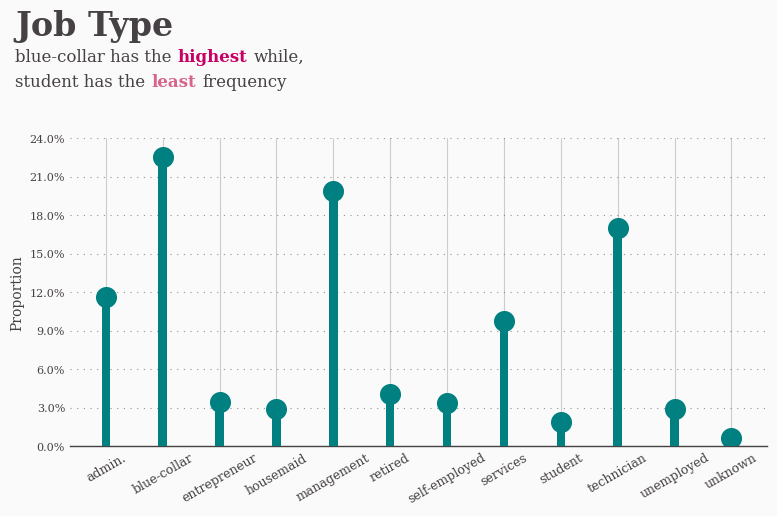

In [10]:
job = data_prep("job", dataframe=df2)
fig = plt.figure(figsize=(9, 4), dpi=100, facecolor=Colors.LightGray)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.35, hspace=0.27)

ax0 = fig.add_subplot(gs[0:1, 0:1])
ax0.set_facecolor(Colors.LightGray)
ax0.tick_params(axis="y", left=False, color=Colors.DarkGray)
ax0.tick_params(axis="x", color=Colors.DarkGray)
ax0.grid(
    which="major",
    axis="y",
    zorder=0,
    color=Colors.Gray,
    linestyle=":",
    dashes=(1, 5),
    alpha=0.65,
)

for sp in ["top", "right", "left"]:
    ax0.spines[sp].set_visible(False)

ax0.spines["bottom"].set_color(Colors.DarkGray)
ax0.bar(job.job, height=job.percentage, zorder=3, color=Colors.Teal, width=0.15)
ax0.scatter(job.job, job.percentage, s=200, color=Colors.Teal)
ax0.set_xticklabels(
    labels=list(job.job),
    rotation=30,
    fontfamily="serif",
    fontsize=9,
    color=Colors.DarkGray,
)
ax0.set_yticklabels(
    ax0.get_yticks(), fontfamily="serif", fontsize=8, color=Colors.DarkGray
)
ax0.yaxis.set_major_formatter(mtick.PercentFormatter())
ax0.yaxis.set_major_locator(mtick.MultipleLocator(3))
ax0.set_ylabel("Proportion", fontfamily="serif", fontsize=10, color=Colors.DarkGray)
ax0.yaxis.set_ticks(np.arange(0, 27, 3))

ax0.text(
    -1.6,
    32,
    "Job Type",
    fontsize=24,
    fontfamily="serif",
    fontweight="bold",
    color=Colors.DarkGray,
)
ax0.text(
    -1.6,
    30,
    "blue-collar has the",
    fontsize=12,
    fontfamily="serif",
    fontweight="normal",
    color=Colors.DarkGray,
)
ax0.text(
    1.25,
    30,
    "highest",
    fontsize=12,
    fontfamily="serif",
    fontweight="bold",
    color=Colors.DeepPink,
)
ax0.text(
    2.6,
    30,
    "while,",
    fontsize=12,
    fontfamily="serif",
    fontweight="normal",
    color=Colors.DarkGray,
)
ax0.text(
    -1.6,
    28,
    "student has the",
    fontsize=12,
    fontfamily="serif",
    fontweight="normal",
    color=Colors.DarkGray,
)
ax0.text(
    0.8,
    28,
    "least",
    fontsize=12,
    fontfamily="serif",
    fontweight="bold",
    color=Colors.HotPink,
)
ax0.text(
    1.7,
    28,
    "frequency",
    fontsize=12,
    fontfamily="serif",
    fontweight="normal",
    color=Colors.DarkGray,
)

fig.show()


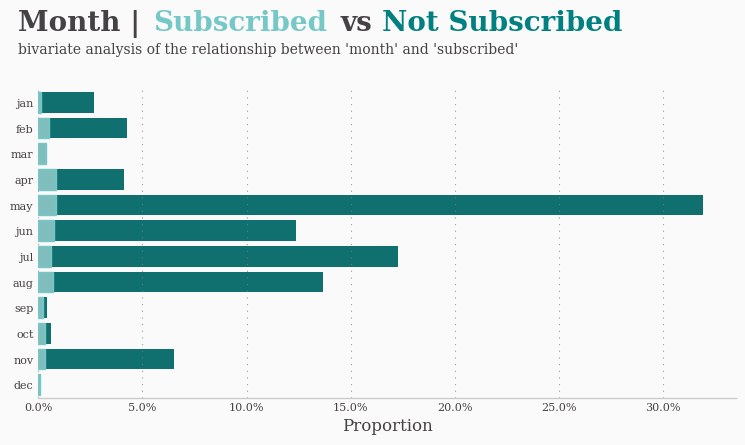

In [11]:
lst = [
    "jan",
    "feb",
    "mar",
    "apr",
    "may",
    "jun",
    "jul",
    "aug",
    "sep",
    "oct",
    "nov",
    "dec",
]

month = data_prep("month", "subscribed", dataframe=df2)
no_subs = month.query("subscribed == 'no'").set_index("month").loc[lst].reset_index()
yes_subs = month.query("subscribed == 'yes'").set_index("month").loc[lst].reset_index()

fig = plt.figure(figsize=(9, 4), dpi=100, facecolor=Colors.LightGray)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.35, hspace=0.27)

ax0 = fig.add_subplot(gs[0:1, 0:1])
ax0.set_facecolor(Colors.LightGray)
ax0.tick_params(axis="both", which="both", length=0)
ax0.grid(
    which="major",
    axis="x",
    zorder=0,
    color="gray",
    linestyle=":",
    dashes=(1, 5),
    alpha=0.8,
)
for x in ["top", "left", "right"]:
    ax0.spines[x].set_visible(False)

sns.barplot(
    x="percentage", y="month", data=no_subs, color=Colors.Teal, ax=ax0, zorder=0
)
sns.barplot(
    x="percentage",
    y="month",
    data=yes_subs,
    color=Colors.Aquamarine,
    ax=ax0,
    ec=Colors.Aquamarine,
)

ax0.xaxis.set_major_formatter(mtick.PercentFormatter())
ax0.xaxis.set_major_locator(mtick.MultipleLocator(5))
plt.yticks(fontfamily="serif", color=Colors.DarkGray, fontsize=8)
plt.xticks(fontfamily="serif", color=Colors.DarkGray, fontsize=8)
ax0.set_xlabel("Proportion", fontfamily="serif", fontsize=12, color=Colors.DarkGray)
ax0.set_ylabel("")

ax0.text(
    -1,
    -2.8,
    "Month |",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)
ax0.text(
    5.5,
    -2.8,
    "Subscribed",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.Aquamarine,
)
ax0.text(
    14.5,
    -2.8,
    "vs",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)
ax0.text(
    16.5,
    -2.8,
    "Not Subscribed",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.Teal,
)

ax0.text(
    -1,
    -1.9,
    "bivariate analysis of the relationship between 'month' and 'subscribed'",
    fontfamily="serif",
    fontsize=10,
    fontweight="normal",
    color=Colors.DarkGray,
)

fig.show()


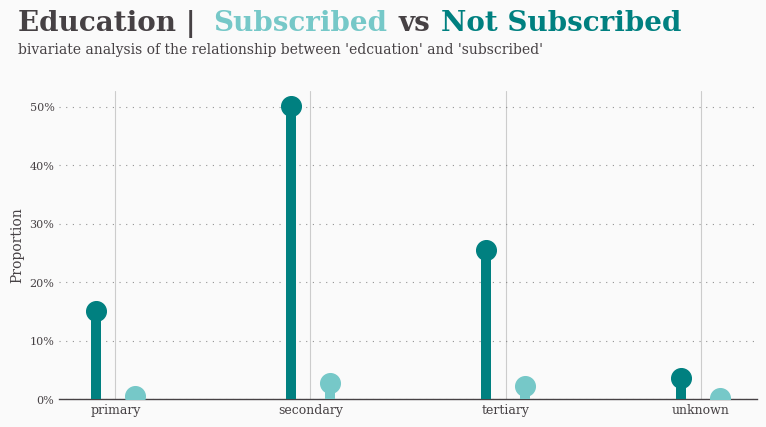

In [12]:
contact = data_prep("education", "subscribed", dataframe=df2)
positive = contact.query("subscribed == 'yes'")
negative = contact.query("subscribed == 'no'")

fig = plt.figure(figsize=(9, 4), dpi=100, facecolor=Colors.LightGray)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.35, hspace=0.27)

ax0 = fig.add_subplot(gs[0:1, 0:1])
ax0.set_facecolor(Colors.LightGray)
ax0.tick_params(axis="y", left=False, color=Colors.DarkGray)
ax0.tick_params(axis="x", color=Colors.DarkGray)
ax0.grid(
    which="major",
    axis="y",
    zorder=0,
    color=Colors.Gray,
    linestyle=":",
    dashes=(1, 5),
    alpha=0.65,
)

for sp in ["top", "right", "left"]:
    ax0.spines[sp].set_visible(False)

ax0.spines["bottom"].set_color(Colors.DarkGray)

ax0.bar(
    negative.education,
    height=negative["percentage"],
    zorder=3,
    color=Colors.Teal,
    width=0.05,
)
ax0.scatter(
    negative.education, negative["percentage"], zorder=3, s=200, color=Colors.Teal
)
ax0.bar(
    np.arange(len(positive.education)) + 0.2,
    height=positive["percentage"],
    zorder=3,
    color=Colors.Aquamarine,
    width=0.05,
)
ax0.scatter(
    np.arange(len(positive.education)) + 0.2,
    positive["percentage"],
    zorder=3,
    s=200,
    color=Colors.Aquamarine,
)
ax0.yaxis.set_major_formatter(mtick.PercentFormatter())
ax0.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax0.set_xticks(np.arange(len(positive.education)) + 0.2 / 2)
ax0.set_xticklabels(list(positive.education), rotation=0)
ax0.set_xticklabels(
    labels=list(positive.education),
    rotation=0,
    fontfamily="serif",
    fontsize=9,
    color=Colors.DarkGray,
)
ax0.set_yticklabels(
    ax0.get_yticks(), fontfamily="serif", fontsize=8, color=Colors.DarkGray
)
ax0.yaxis.set_major_formatter(mtick.PercentFormatter())
ax0.yaxis.set_major_locator(mtick.MultipleLocator(3))
ax0.set_ylabel("Proportion", fontfamily="serif", fontsize=10, color=Colors.DarkGray)
ax0.yaxis.set_ticks(np.arange(0, 60, 10))
ax0.text(
    -0.4,
    63,
    "Education |",
    fontsize=20,
    fontweight="bold",
    fontfamily="serif",
    color=Colors.DarkGray,
)
ax0.text(
    0.6,
    63,
    "Subscribed",
    fontsize=20,
    fontweight="bold",
    fontfamily="serif",
    color=Colors.Aquamarine,
)
ax0.text(
    1.55,
    63,
    "vs",
    fontsize=20,
    fontweight="bold",
    fontfamily="serif",
    color=Colors.DarkGray,
)
ax0.text(
    1.77,
    63,
    "Not Subscribed",
    fontsize=20,
    fontweight="bold",
    fontfamily="serif",
    color=Colors.Teal,
)
ax0.text(
    -0.4,
    59,
    "bivariate analysis of the relationship between 'edcuation' and 'subscribed'",
    fontfamily="serif",
    fontsize=10,
    fontweight="normal",
    color=Colors.DarkGray,
)
fig.show()


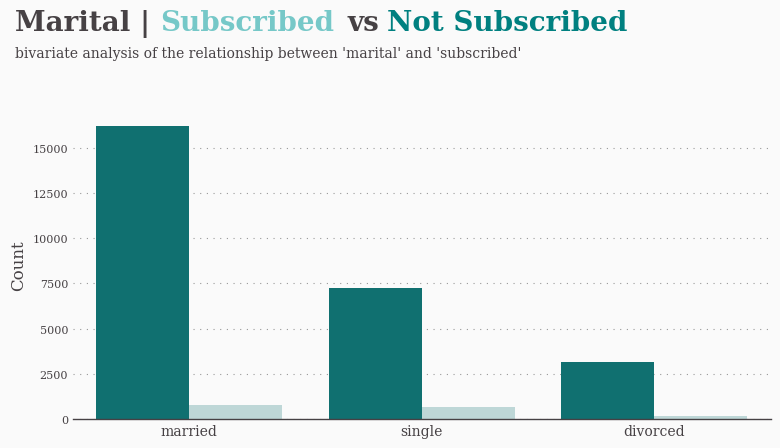

In [13]:
fig = plt.figure(figsize=(9, 4), dpi=100, facecolor=Colors.LightGray)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0:1, 0:1])
ax0.set_facecolor(Colors.LightGray)
ax0.grid(
    which="major",
    axis="y",
    zorder=0,
    color="gray",
    linestyle=":",
    dashes=(1, 5),
    alpha=0.8,
)
ax0.tick_params(axis="both", which="both", length=0)
ax0.set_xlabel("")
ax0.set_ylabel("")
for sp in ["top", "right", "left"]:
    ax0.spines[sp].set_visible(False)
ax0.spines["bottom"].set_color(Colors.DarkGray)

sns.countplot(
    data=df2,
    x="marital",
    hue="subscribed",
    palette=[Colors.Teal, Colors.LightCyan],
    ax=ax0,
)
ax0.get_legend().remove()
ax0.yaxis.set_major_locator(mtick.MultipleLocator(2500))
ax0.set_xticklabels(
    labels=list(df2["marital"].unique()),
    fontfamily="serif",
    fontsize=10,
    color=Colors.DarkGray,
)
plt.yticks(fontfamily="serif", color=Colors.DarkGray, fontsize=8)
ax0.set_xlabel("")
ax0.set_ylabel("Count", fontfamily="serif", fontsize=12, color=Colors.DarkGray)

ax0.text(
    -0.75,
    21500,
    "Marital |",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)
ax0.text(
    -0.125,
    21500,
    "Subscribed",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.Aquamarine,
)
ax0.text(
    0.68,
    21500,
    "vs",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)
ax0.text(
    0.85,
    21500,
    "Not Subscribed",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.Teal,
)
ax0.text(
    -0.75,
    20000,
    "bivariate analysis of the relationship between 'marital' and 'subscribed'",
    fontfamily="serif",
    fontsize=10,
    fontweight="normal",
    color=Colors.DarkGray,
)

fig.show()


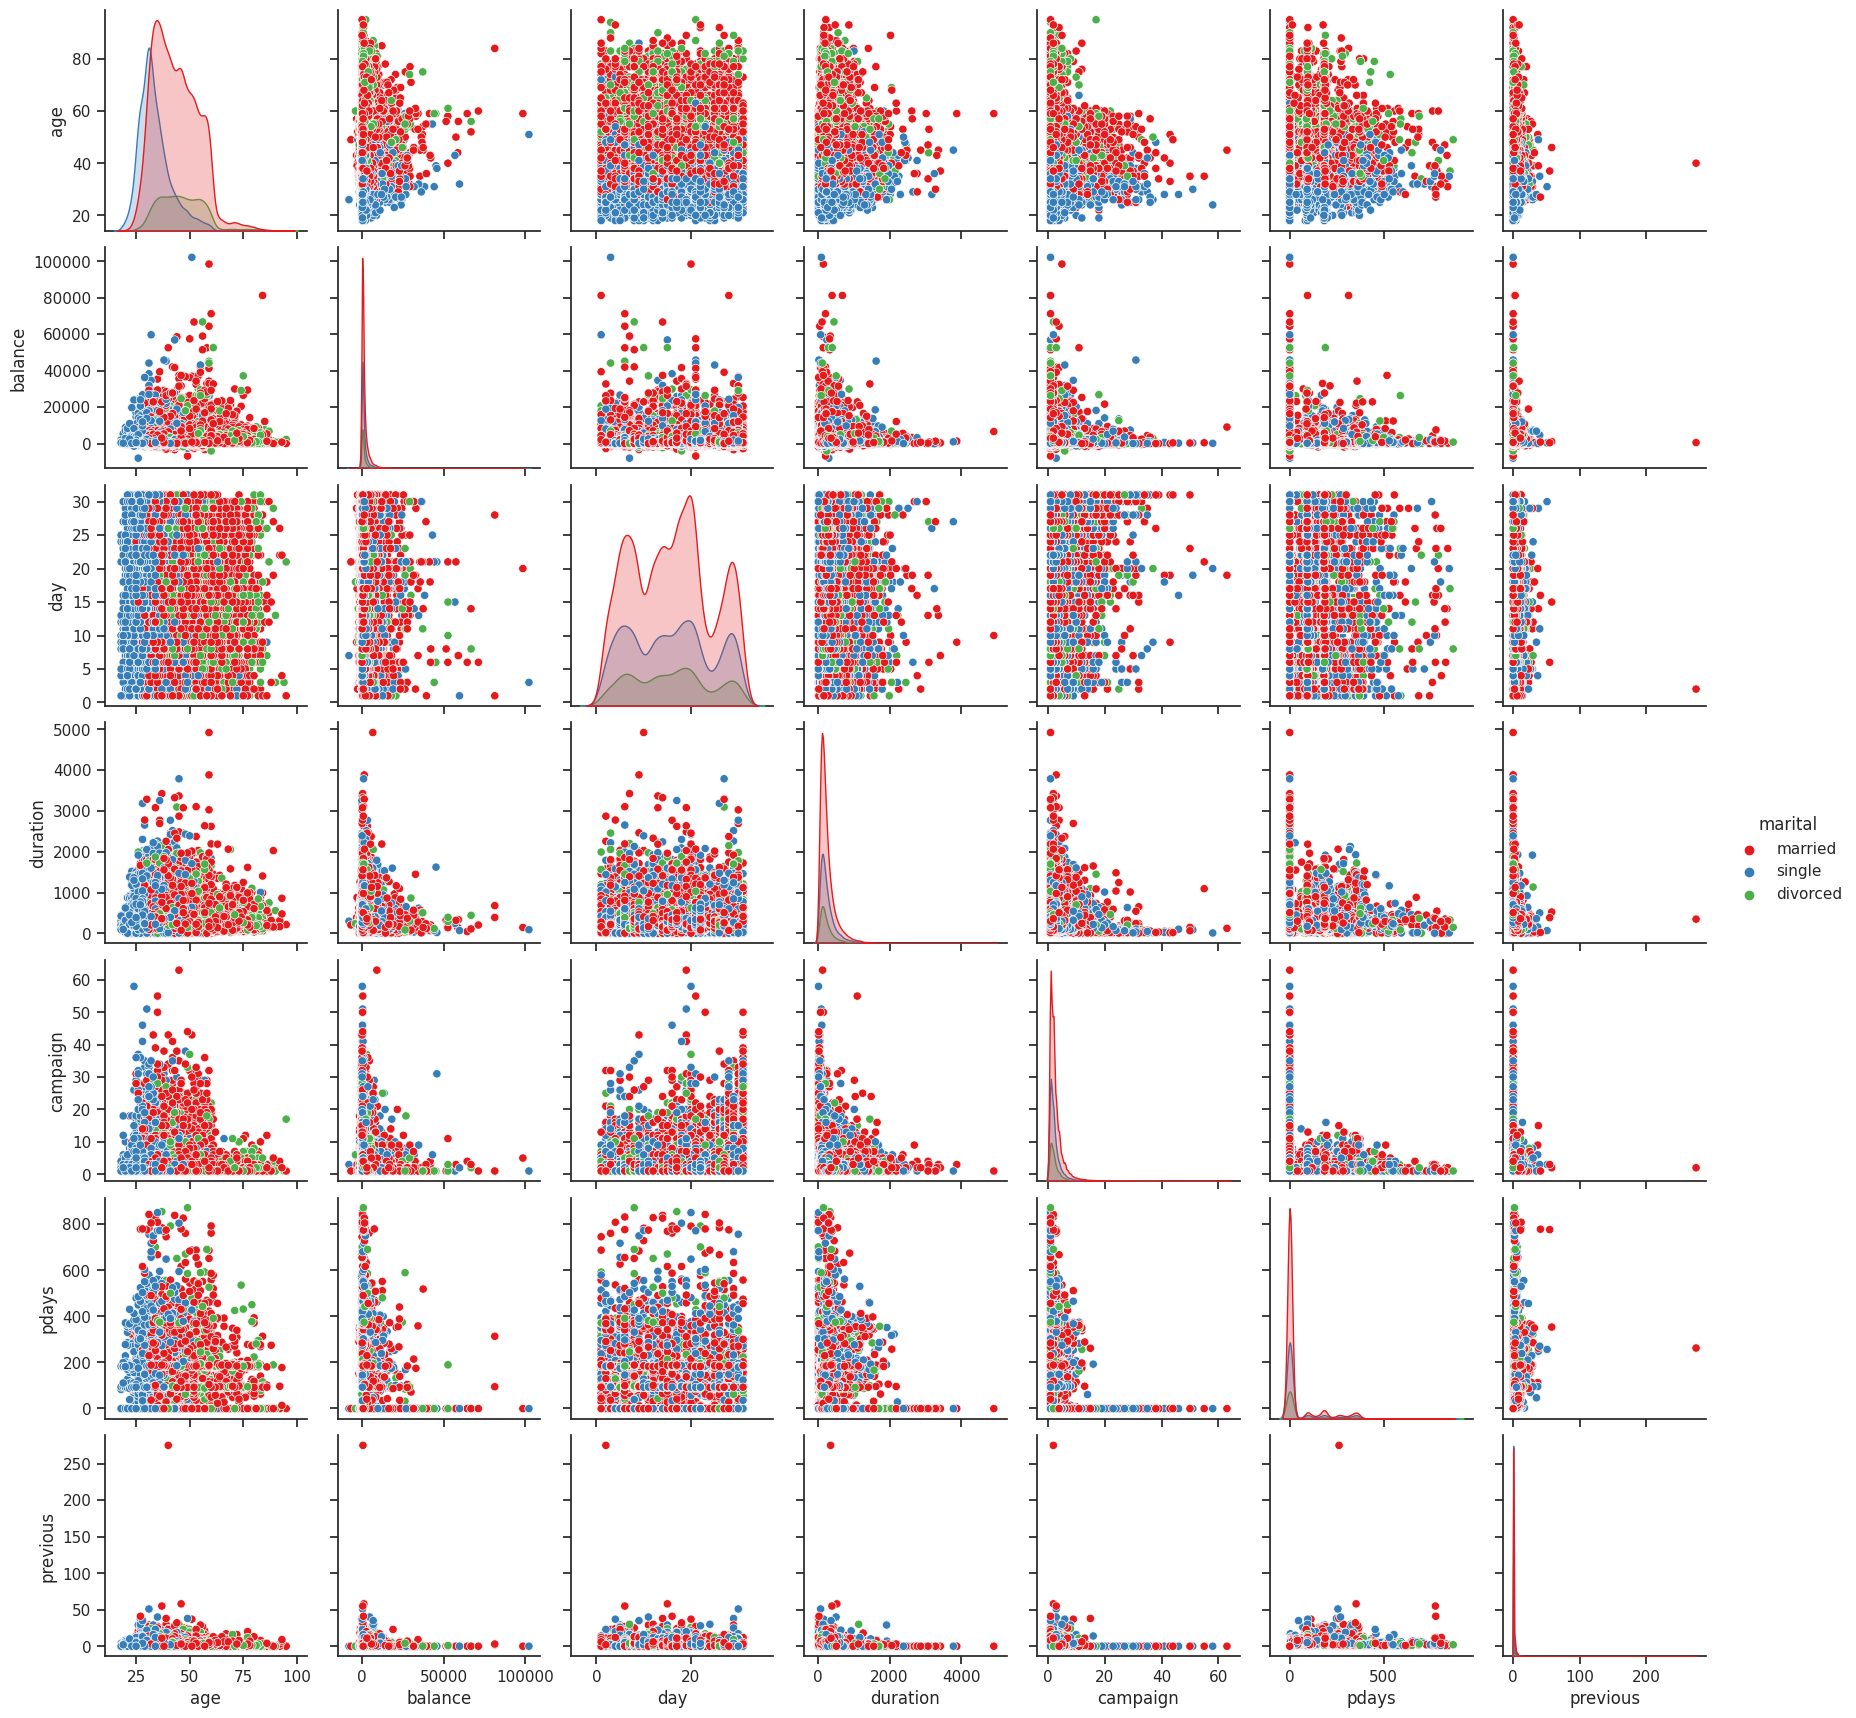

In [24]:
sns.set(style="ticks")
sns.pairplot(df, hue="marital", palette="Set1")
plt.show()


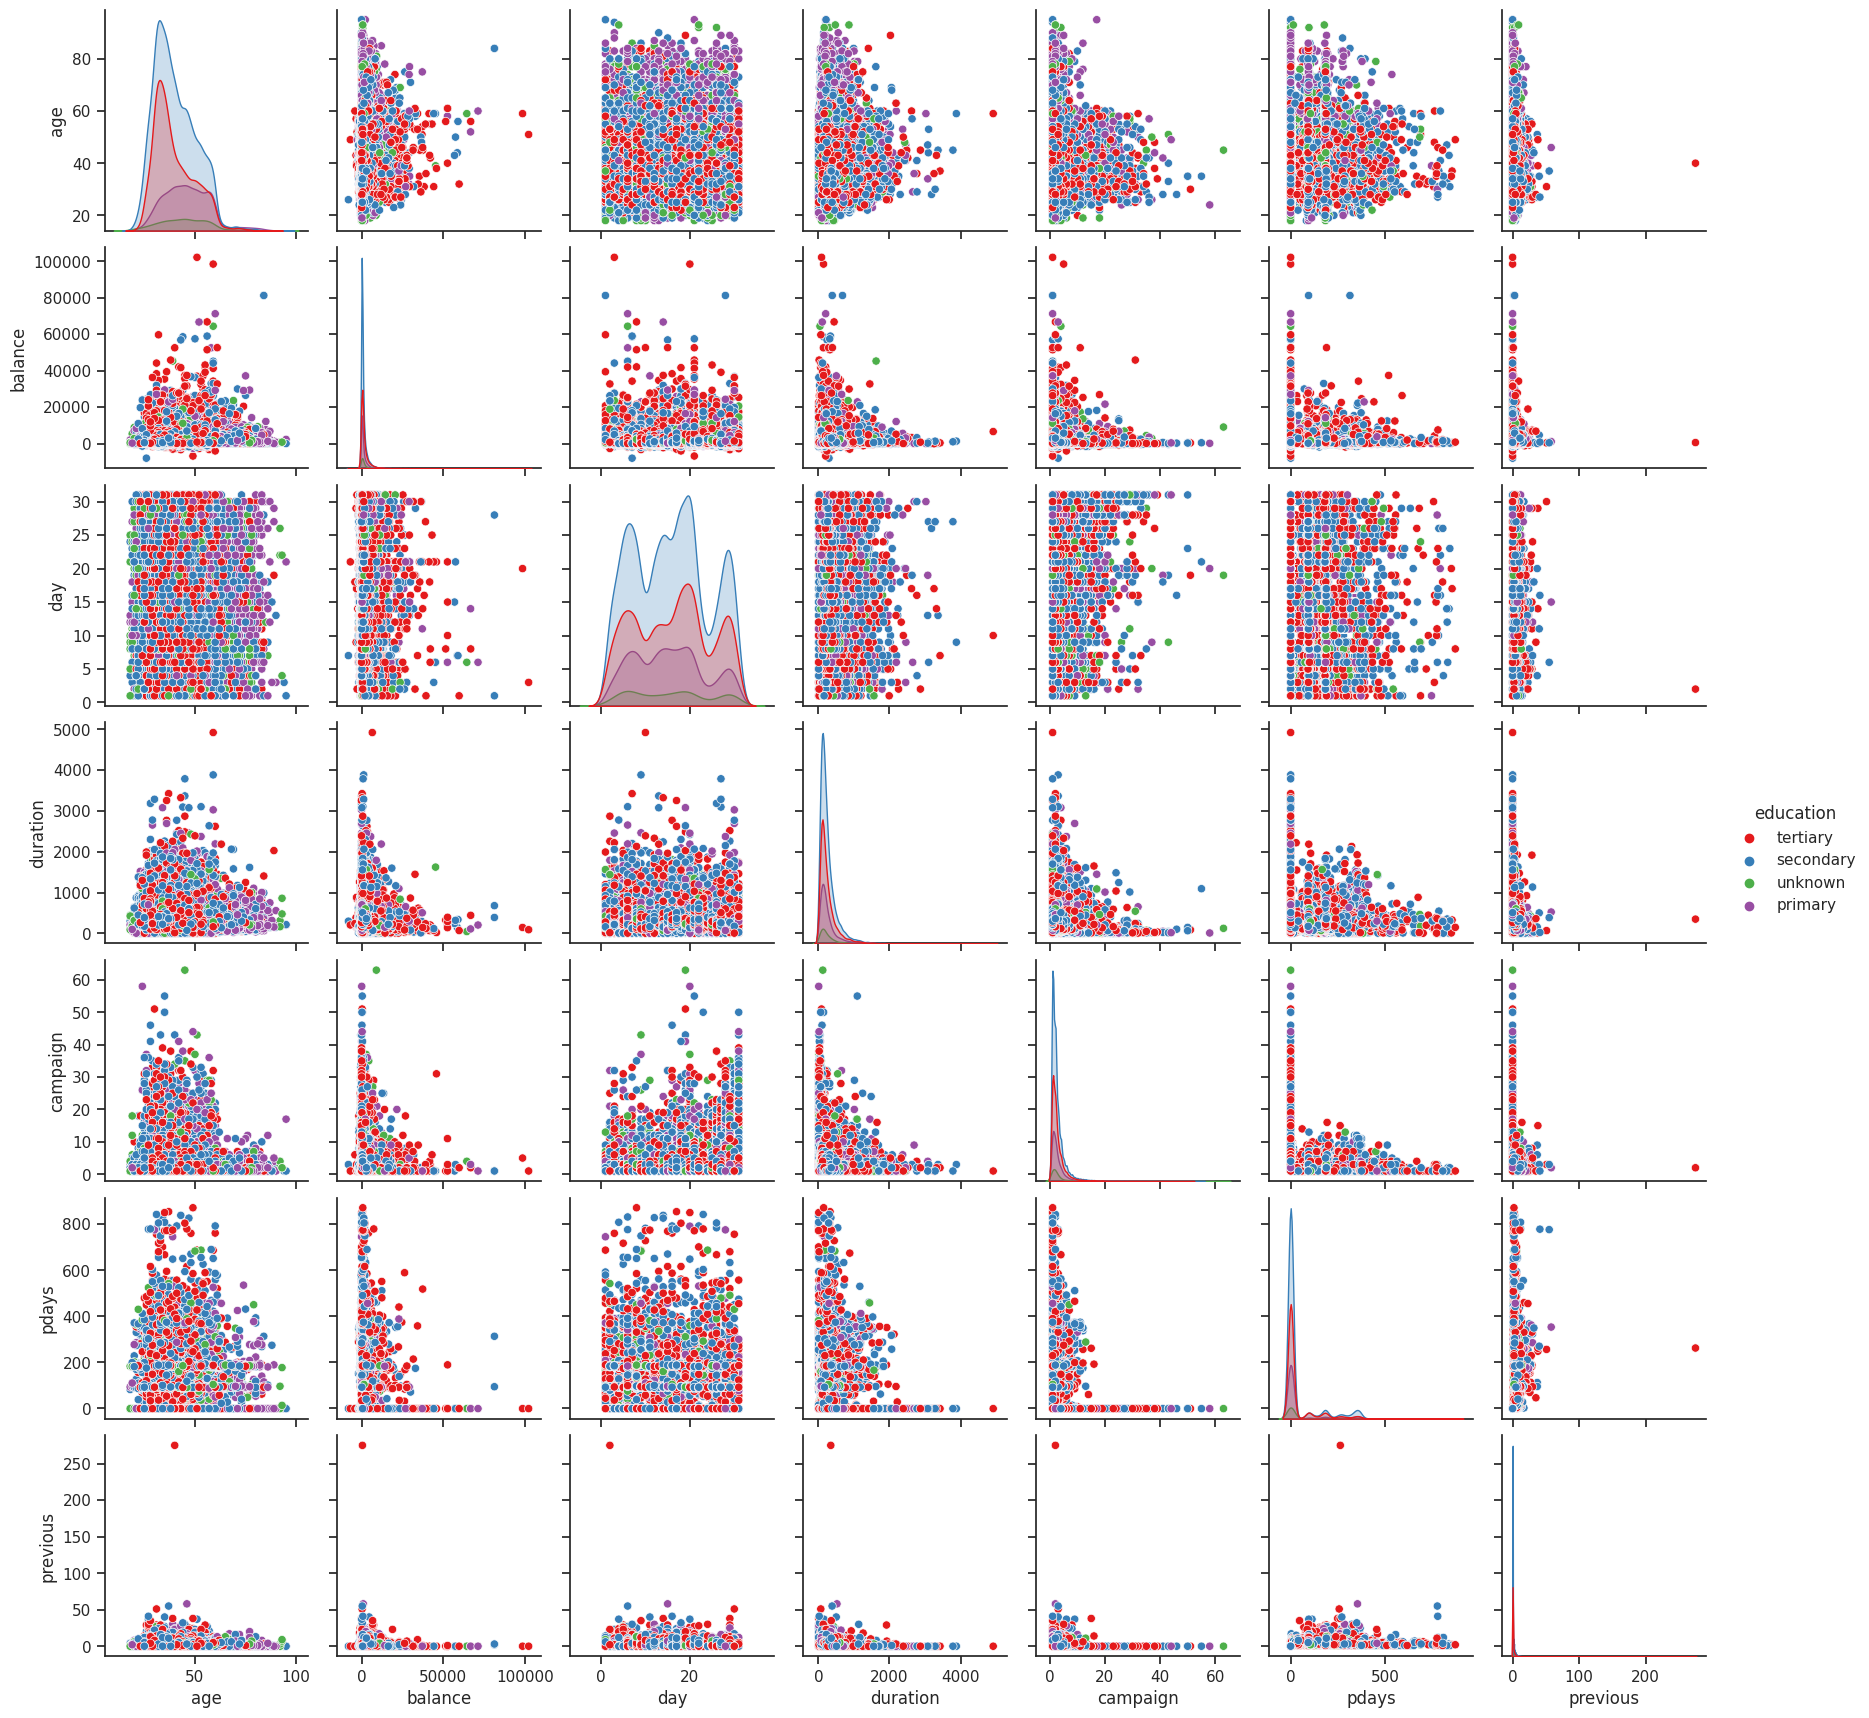

In [25]:
sns.pairplot(df, hue="education", palette="Set1")
plt.show()

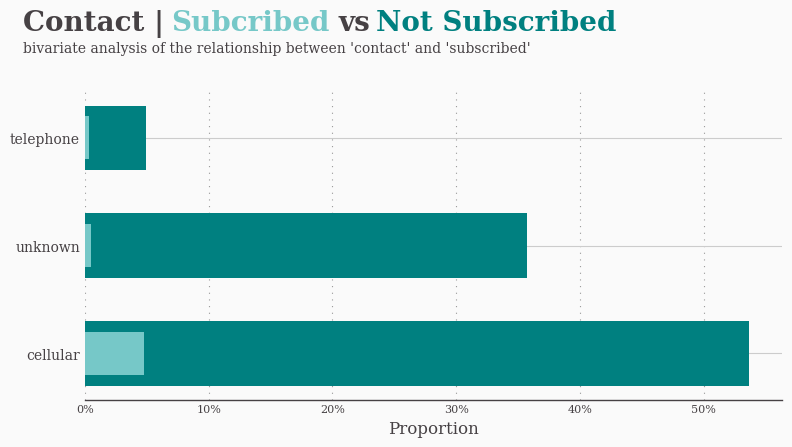

In [14]:
data = data_prep("contact", "subscribed", dataframe=df2)
positive = data.query("subscribed == 'yes'").sort_values(
    by="percentage", ascending=False
)
negative = data.query("subscribed == 'no'").sort_values(
    by="percentage", ascending=False
)

fig = plt.figure(figsize=(9, 4), dpi=100, facecolor=Colors.LightGray)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.35, hspace=0.27)

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(Colors.LightGray)
ax0.grid(
    which="major",
    axis="x",
    zorder=0,
    color="gray",
    linestyle=":",
    dashes=(1, 5),
    alpha=0.8,
)
ax0.tick_params(axis="both", which="both", length=0)
ax0.set_xlabel("")
ax0.set_ylabel("")
for sp in ["top", "right", "left"]:
    ax0.spines[sp].set_visible(False)
ax0.spines["bottom"].set_color(Colors.DarkGray)


ax0.barh(negative.contact, negative.percentage, color=Colors.Teal, zorder=3, height=0.6)
ax0.barh(
    positive.contact, positive.percentage, color=Colors.Aquamarine, zorder=3, height=0.4
)

ax0.xaxis.set_major_formatter(mtick.PercentFormatter())
ax0.xaxis.set_major_locator(mtick.MultipleLocator(10))
plt.yticks(fontfamily="serif", color=Colors.DarkGray, fontsize=10)
plt.xticks(fontfamily="serif", color=Colors.DarkGray, fontsize=8)
ax0.set_xlabel("Proportion", fontfamily="serif", fontsize=12, color=Colors.DarkGray)

ax0.text(
    -5,
    3,
    "Contact |",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)
ax0.text(
    7,
    3,
    "Subcribed",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.Aquamarine,
)
ax0.text(
    20.5,
    3,
    "vs",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)
ax0.text(
    23.5,
    3,
    "Not Subscribed",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.Teal,
)
ax0.text(
    -5,
    2.8,
    "bivariate analysis of the relationship between 'contact' and 'subscribed'",
    fontfamily="serif",
    fontsize=10,
    fontweight="normal",
    color=Colors.DarkGray,
)

fig.show()


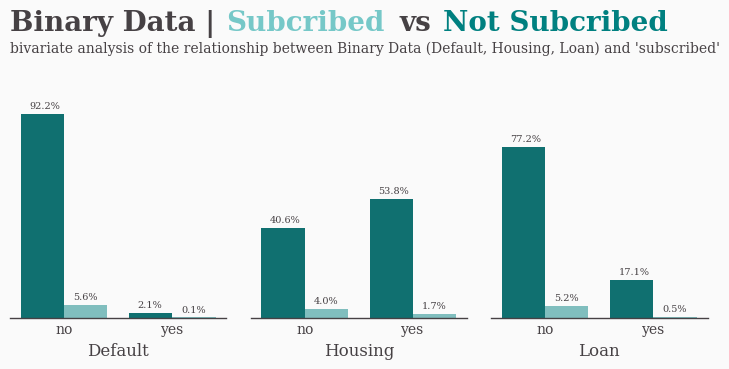

In [15]:
default = data_prep("default", "subscribed", dataframe=df2)
housing = data_prep("housing", "subscribed", dataframe=df2)
loan = data_prep("loan", "subscribed", dataframe=df2)
fig = plt.figure(figsize=(9, 6), dpi=100, facecolor=Colors.LightGray)
gs = fig.add_gridspec(4, 6, wspace=0.25)
left = 0
right = 2
for ax in range(0, 3):
    locals()["axis" + str(ax)] = fig.add_subplot(gs[0:2, left:right])
    locals()["axis" + str(ax)].grid(
        which="major",
        axis="y",
        zorder=0,
        color="gray",
        linestyle=":",
        dashes=(1, 5),
        alpha=0.65,
    )
    locals()["axis" + str(ax)].set_facecolor(Colors.LightGray)
    locals()["axis" + str(ax)].tick_params(axis="x", bottom=False)
    locals()["axis" + str(ax)].tick_params(axis="y", left=False)
    locals()["axis" + str(ax)].get_yaxis().set_visible(False)
    spines = ["top", "left", "right"]
    for sp in spines:
        locals()["axis" + str(ax)].spines[sp].set_visible(False)
        locals()["axis" + str(ax)].spines["bottom"].set_color(Colors.DarkGray)

    left += 2
    right += 2

for ax, data in zip(range(3), [default, housing, loan]):
    sns.barplot(
        data=data,
        x=data.columns[0],
        y="percentage",
        hue="subscribed",
        ax=locals()["axis" + str(ax)],
        palette=[Colors.Teal, Colors.Aquamarine],
    )
    locals()["axis" + str(ax)].yaxis.set_major_formatter(mtick.PercentFormatter())
    locals()["axis" + str(ax)].yaxis.set_major_locator(mtick.MultipleLocator(10))
    locals()["axis" + str(ax)].yaxis.set_ticks(np.arange(0, 110, 10))
    locals()["axis" + str(ax)].get_legend().remove()
    locals()["axis" + str(ax)].set_xticklabels(
        labels=["no", "yes"],
        fontfamily="serif",
        fontsize=10,
        color=Colors.DarkGray,
    )
    locals()["axis" + str(ax)].set_xlabel(
        data.columns[0].title(),
        fontfamily="serif",
        fontsize=12,
        color=Colors.DarkGray,
    )
    for p in locals()["axis" + str(ax)].patches:
        locals()["axis" + str(ax)].annotate(
            f"{round(p.get_height(), 1)}%",
            (p.get_x() + 0.08, p.get_height() + 2.5),
            fontsize=7,
            fontweight="normal",
            fontfamily="serif",
            color=Colors.DarkGray,
        )


axis0.text(
    -0.5,
    130,
    "Binary Data |",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)
axis0.text(
    -0.5,
    120,
    "bivariate analysis of the relationship between Binary Data (Default, Housing, Loan) and 'subscribed'",
    fontfamily="serif",
    fontsize=10,
    fontweight="normal",
    color=Colors.DarkGray,
)
axis0.text(
    1.5,
    130,
    "Subcribed",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.Aquamarine,
)
axis0.text(
    3.5,
    130,
    "Not Subcribed",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.Teal,
)
axis0.text(
    3.1,
    130,
    "vs",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)

fig.show()


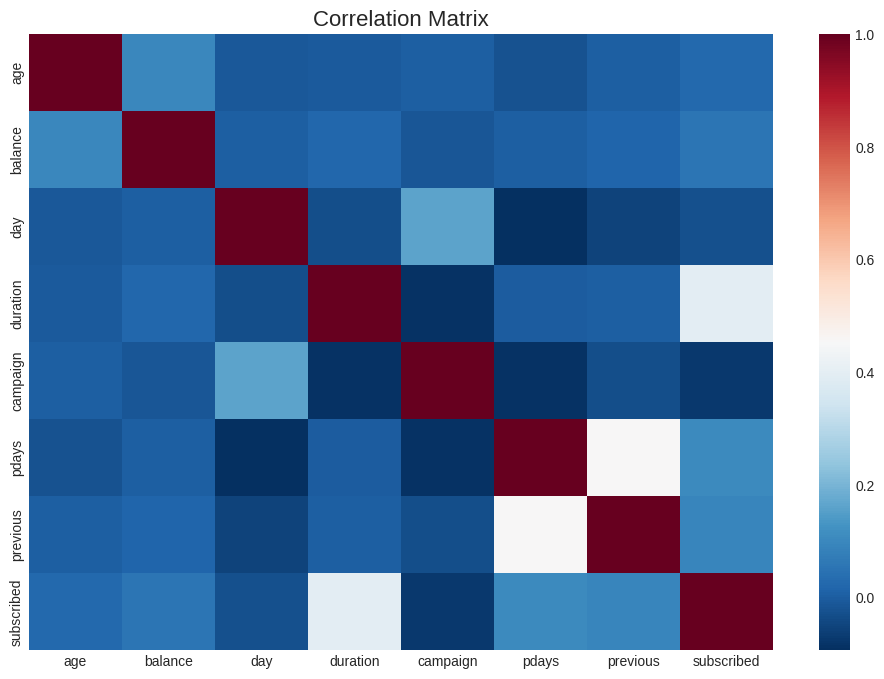

In [16]:
fig = plt.figure(figsize=(12, 8))
df["subscribed"] = LabelEncoder().fit_transform(df["subscribed"])

numeric_df = df.select_dtypes(exclude="object")
corr_numeric = numeric_df.corr()

sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()


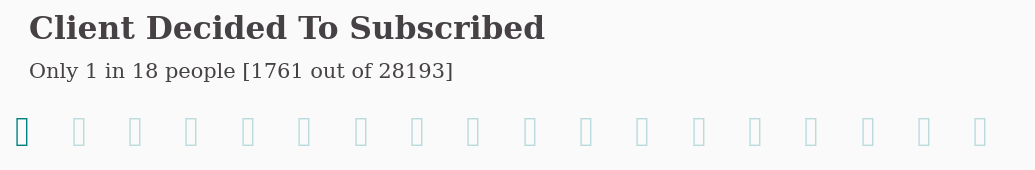

In [17]:
subs = data_prep("subscribed", dataframe=df2)
subs = subs.sort_index()

fig = plt.figure(
    figsize=(7, 2),
    dpi=150,
    facecolor=Colors.LightGray,
    FigureClass=Waffle,
    rows=1,
    values=[1, 17],
    colors=[Colors.Teal, Colors.LightCyan],
    characters="⬤",
    font_size=20,
    vertical=True,
)

fig.text(
    0.035,
    0.78,
    "Client Decided To Subscribed",
    fontfamily="serif",
    fontsize=15,
    fontweight="bold",
    color=Colors.DarkGray,
)
fig.text(
    0.035,
    0.65,
    f"Only 1 in 18 people [1761 out of {len(df2)}]",
    fontfamily="serif",
    fontsize=10,
    color=Colors.DarkGray,
)

fig.show()

### Data Preprocessing

In [18]:
col_names = ["job", "education", "contact"]

for col in col_names:
    print(f"Before | {col} = {df2[col].unique()}")
    df2[col].replace(["unknown"], df2[col].mode(), inplace=True)
    print(f"After | {col} = {df2[col].unique()}\n")

Before | job = ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
After | job = ['management' 'technician' 'entrepreneur' 'blue-collar' 'retired' 'admin.'
 'services' 'self-employed' 'unemployed' 'housemaid' 'student']

Before | education = ['tertiary' 'secondary' 'unknown' 'primary']
After | education = ['tertiary' 'secondary' 'primary']

Before | contact = ['unknown' 'cellular' 'telephone']
After | contact = ['cellular' 'telephone']



In [19]:
df2.drop(columns=["month", "previous", "day", "pdays", "poutcome"], inplace=True)
df2.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married  secondary      no     1506     yes   no   
4   33   blue-collar   single  secondary      no        1      no   no   

    contact  duration  campaign subscribed  
0  cellular       261         1         no  
1  cellular       151         1         no  
2  cellular        76         1         no  
3  cellular        92         1         no  
4  cellular       198         1         no

In [20]:
class Encoding:
    def __init__(self, data: pd.DataFrame):
        self.dataframe = data
        self.data = None
    
    def encoding_binary_data(self, binary_data: list):
        for col in binary_data:
            if col == 'contact':
                self.dataframe[col] = self.dataframe[col].map({
                    'telephone': 1,
                    'cellular' : 0
                })

            else:
                self.dataframe[col] = self.dataframe[col].map({
                    'yes': 1,
                    'no' : 0
                })
        
        self.data = self.dataframe
        return self
    
    def encoding_nonbinary_data(self, var: list):
        for col in var:
            self.dataframe[col] = LabelEncoder().fit_transform(self.dataframe[col])
        
        self.data = self.dataframe
        return self
    
    def fetch(self) -> pd.DataFrame:
        return self.data
    
encoding = Encoding(data = df2)\
    .encoding_binary_data(['default', 'housing', 'loan', 'contact'])\
    .encoding_nonbinary_data(['job', 'marital', 'education','subscribed'])

In [21]:
df2 = encoding.fetch()

In [22]:
x = df2.drop('subscribed', axis = 1)
y = df2.loc[:, 'subscribed']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

### Oversampling

In [23]:
oversampling = SMOTE(random_state=1)
X_train_oversampling, y_train_oversampling = oversampling.fit_resample(X_train, y_train)

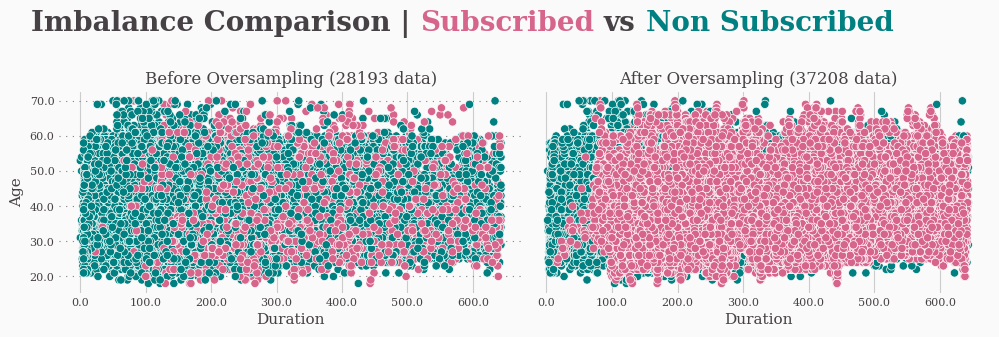

In [24]:
after_smote_df2 = pd.concat([X_train_oversampling, y_train_oversampling], axis=1)

fig = plt.figure(figsize=(12, 12), dpi=100, facecolor=Colors.LightGray)
gs = fig.add_gridspec(4, 2, wspace=0.01)


for ax, col in enumerate(range(0, 2)):
    locals()["ax" + str(ax)] = fig.add_subplot(gs[0, col])
    locals()["ax" + str(ax)].set_facecolor(Colors.LightGray)
    locals()["ax" + str(ax)].tick_params(axis="y", left=False)
    locals()["ax" + str(ax)].tick_params(axis="x", bottom=False, color=Colors.DarkGray)
    locals()["ax" + str(ax)].get_yaxis().set_visible(True)
    locals()["ax" + str(ax)].grid(
        which="major", axis="y", zorder=0, color="gray", linestyle=":", dashes=(1, 5)
    )
    for s in ["top", "right", "left", "bottom"]:
        locals()["ax" + str(ax)].spines[s].set_visible(False)

color_palette = [Colors.Teal, Colors.HotPink]

sns.scatterplot(
    data=df2, x="duration", y="age", hue="subscribed", ax=ax0, palette=color_palette
).set_title(
    f"Before Oversampling ({len(df2.subscribed)} data)",
    fontsize=12,
    fontfamily="serif",
    color=Colors.DarkGray,
)
sns.scatterplot(
    data=after_smote_df2,
    x="duration",
    y="age",
    hue="subscribed",
    ax=ax1,
    palette=color_palette,
).set_title(
    f"After Oversampling ({len(after_smote_df2.subscribed)} data)",
    fontsize=12,
    fontfamily="serif",
    color=Colors.DarkGray,
)

for ax in range(2):
    locals()["ax" + str(ax)].get_legend().remove()
    locals()["ax" + str(ax)].set_xlabel(
        "Duration", fontfamily="serif", fontsize=11, color=Colors.DarkGray
    )
    locals()["ax" + str(ax)].set_ylabel(
        "Age", fontfamily="serif", fontsize=11, color=Colors.DarkGray
    )
    locals()["ax" + str(ax)].set_xticklabels(
        labels=ax0.get_xticks().tolist(),
        fontfamily="serif",
        fontsize=8,
        color=Colors.DarkGray,
    )
    locals()["ax" + str(ax)].set_yticklabels(
        labels=ax0.get_yticks().tolist(),
        fontfamily="serif",
        fontsize=8,
        color=Colors.DarkGray,
    )

ax1.get_yaxis().set_visible(False)

ax0.text(
    -75,
    90,
    "Imbalance Comparison |",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)
ax0.text(
    520,
    90,
    "Subscribed",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.HotPink,
)
ax0.text(
    800,
    90,
    "vs",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.DarkGray,
)
ax0.text(
    865,
    90,
    "Non Subscribed",
    fontfamily="serif",
    fontsize=20,
    fontweight="bold",
    color=Colors.Teal,
)

fig.show()

### Logistic Regression

In [25]:
logreg_params = {"penalty": ["l1", "l2"], "C": [0.001, 0.01, 0.1, 1, 10, 100]}
gcv_logreg = GridSearchCV(
    LogisticRegression(random_state=1), param_grid=logreg_params, cv=10, scoring="f1"
)
logreg_gcv = gcv_logreg.fit(X_train_oversampling, y_train_oversampling)
print(f"Best Parameter: {logreg_gcv.best_params_}")
print(f"Best Score: {logreg_gcv.best_score_}")

Best Parameter: {'C': 100, 'penalty': 'l2'}
Best Score: 0.8446913939150115


In [26]:
logreg_pred = logreg_gcv.best_estimator_.predict(X_test)

print(classification_report(y_test, logreg_pred))
print("Accuracy Score: ", accuracy_score(y_test, logreg_pred))
print(f"F1 Score: {f1_score(y_test,logreg_pred)}")

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      7990
           1       0.17      0.65      0.27       468

    accuracy                           0.81      8458
   macro avg       0.57      0.73      0.58      8458
weighted avg       0.93      0.81      0.86      8458

Accuracy Score:  0.8082288957200284
F1 Score: 0.27133872416891286


### XGBoost

In [39]:
estimator = XGBClassifier(objective="binary:logistic", nthread=4, seed=42)
parameters = {
    "max_depth": range(2, 10, 1),
    "n_estimators": range(60, 220, 40),
    "learning_rate": [0.1, 0.01, 0.05],
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring="roc_auc",
    n_jobs=5,
    cv=5,
    verbose=True,
)

grid_search.fit(X_train_oversampling, y_train_oversampling)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='roc_auc', verbose=True)

In [40]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [42]:
xgb_pred = grid_search.best_estimator_.predict(X_test)

print(classification_report(y_test, xgb_pred))
print("Accuracy Score: ", accuracy_score(y_test, xgb_pred))
print(f"F1 Score: {f1_score(y_test,logreg_pred)}")

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      7990
           1       0.20      0.37      0.26       468

    accuracy                           0.89      8458
   macro avg       0.58      0.64      0.60      8458
weighted avg       0.92      0.89      0.90      8458

Accuracy Score:  0.8850792149444313
F1 Score: 0.27133872416891286


In [27]:
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [200, 500],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [4, 5, 6, 7, 8],
    "criterion": ["gini", "entropy"],
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train_oversampling, y_train_oversampling)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [28]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

### Naive Bayes

In [29]:
nb_params = {"var_smoothing": np.logspace(0, -9, num=100)}
gcv_nb = GridSearchCV(GaussianNB(), param_grid=nb_params, cv=10, scoring="f1")

nb_gcv = gcv_nb.fit(X_train_oversampling, y_train_oversampling)
print(f"Best Parameter: {nb_gcv.best_params_}")
print(f"Best Score: {nb_gcv.best_score_}")

Best Parameter: {'var_smoothing': 2.310129700083158e-07}
Best Score: 0.8363270340818583


In [30]:
nb_pred = nb_gcv.best_estimator_.predict(X_test)

print(classification_report(y_test, nb_pred))
print("Accuracy Score: ", accuracy_score(y_test, nb_pred))
print(f"F1 Score: {f1_score(y_test,nb_pred)}\n")

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      7990
           1       0.13      0.74      0.22       468

    accuracy                           0.70      8458
   macro avg       0.55      0.72      0.52      8458
weighted avg       0.93      0.70      0.78      8458

Accuracy Score:  0.7034759990541499
F1 Score: 0.21575984990619135



### Decision Tree

In [31]:
dt_params = {"criterion": ["gini", "entropy"], "max_depth": np.arange(3, 15)}
gcv_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=1), param_grid=dt_params, cv=10, scoring="f1"
)

dt_gcv = gcv_dt.fit(X_train_oversampling, y_train_oversampling)
print(f"Best Parameter: {dt_gcv.best_params_}")
print(f"Best Score: {dt_gcv.best_score_}")

Best Parameter: {'criterion': 'gini', 'max_depth': 14}
Best Score: 0.8972894563786203


In [32]:
dt_pred = dt_gcv.best_estimator_.predict(X_test)
print(classification_report(y_test, dt_pred))
print('Accuracy Score: ',accuracy_score(y_test,dt_pred))
print(f'F1 Score: {f1_score(y_test,dt_pred)}\n')

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      7990
           1       0.15      0.44      0.22       468

    accuracy                           0.83      8458
   macro avg       0.55      0.64      0.56      8458
weighted avg       0.92      0.83      0.87      8458

Accuracy Score:  0.8285646724994088
F1 Score: 0.21959095801937564



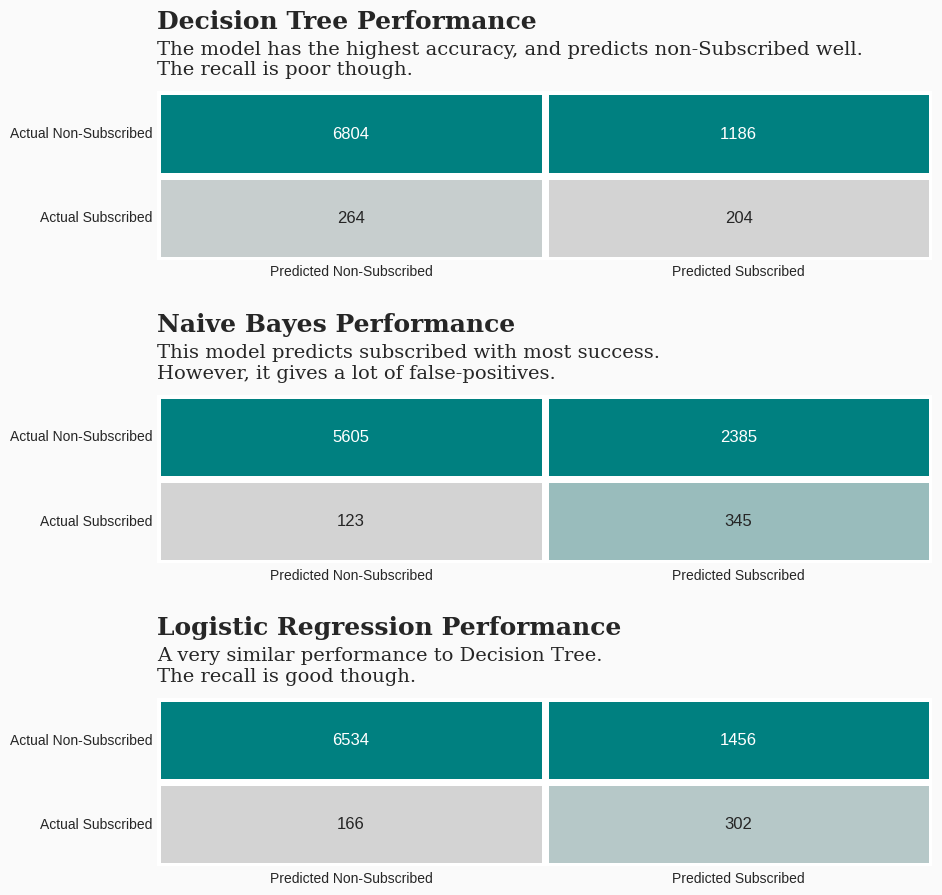

In [33]:
colors = [
    "lightgray",
    Colors.Teal,
    Colors.Teal,
    Colors.Teal,
    Colors.Teal,
    Colors.Teal,
    Colors.Teal,
    Colors.Teal,
]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
fig = plt.figure(figsize=(10, 14), facecolor=Colors.LightGray)  # create figure
gs = fig.add_gridspec(4, 2, wspace=0.1, hspace=0.8)

for ax in range(3):
    locals()["ax" + str(ax)] = fig.add_subplot(gs[ax, :])
    locals()["ax" + str(ax)].set_facecolor(Colors.LightGray)
    locals()["ax" + str(ax)].tick_params(axis="both", which="both", length=0)
dt_cm = confusion_matrix(y_test, dt_pred)
sns.heatmap(
    dt_cm,
    cmap=colormap,
    annot=True,
    fmt="d",
    linewidths=5,
    cbar=False,
    ax=ax0,
    yticklabels=["Actual Non-Subscribed", "Actual Subscribed"],
    xticklabels=["Predicted Non-Subscribed", "Predicted Subscribed"],
    annot_kws={"fontsize": 12},
)
nb_cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(
    nb_cm,
    cmap=colormap,
    annot=True,
    fmt="d",
    linewidths=5,
    cbar=False,
    ax=ax1,
    yticklabels=["Actual Non-Subscribed", "Actual Subscribed"],
    xticklabels=["Predicted Non-Subscribed", "Predicted Subscribed"],
    annot_kws={"fontsize": 12},
)
logreg_cm = confusion_matrix(y_test, logreg_pred)
sns.heatmap(
    logreg_cm,
    cmap=colormap,
    annot=True,
    fmt="d",
    linewidths=5,
    cbar=False,
    ax=ax2,
    yticklabels=["Actual Non-Subscribed", "Actual Subscribed"],
    xticklabels=["Predicted Non-Subscribed", "Predicted Subscribed"],
    annot_kws={"fontsize": 12},
)

ax0.text(
    0,
    -0.75,
    "Decision Tree Performance",
    fontsize=18,
    fontweight="bold",
    fontfamily="serif",
)
ax0.text(
    0,
    -0.2,
    "The model has the highest accuracy, and predicts non-Subscribed well.\nThe recall is poor though.",
    fontsize=14,
    fontfamily="serif",
)
ax1.text(
    0,
    -0.75,
    "Naive Bayes Performance",
    fontsize=18,
    fontweight="bold",
    fontfamily="serif",
)
ax1.text(
    0,
    -0.2,
    "This model predicts subscribed with most success.\nHowever, it gives a lot of false-positives.",
    fontsize=14,
    fontfamily="serif",
)
ax2.text(
    0,
    -0.75,
    "Logistic Regression Performance",
    fontsize=18,
    fontweight="bold",
    fontfamily="serif",
)
ax2.text(
    0,
    -0.2,
    "A very similar performance to Decision Tree.\nThe recall is good though.",
    fontsize=14,
    fontfamily="serif",
)

fig.show()


In [34]:
def dataframe_to_plot(title, classification_cm) -> pd.DataFrame:
    tn, fp, fn, tp = classification_cm.ravel()
    accuracy = (tp + tn) / (tn + tp + fn + fp)
    sensitivity = tp / (fn + tp)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = 2 * (1 / ((1 / precision) + (1 / sensitivity)))
    metrics = pd.DataFrame(
        data=[f1, accuracy, sensitivity, specificity, precision],
        columns=[title],
        index=["F1", "Accuracy", "Recall", "Specificity", "Precision"],
    )
    return metrics


logreg_df = dataframe_to_plot("Tuned Logistic Regression Score", logreg_cm)
navbayes_df = dataframe_to_plot("Tuned Naive Bayes Score", nb_cm)
dectree_df = dataframe_to_plot("Tuned Decision Tree Score", dt_cm)


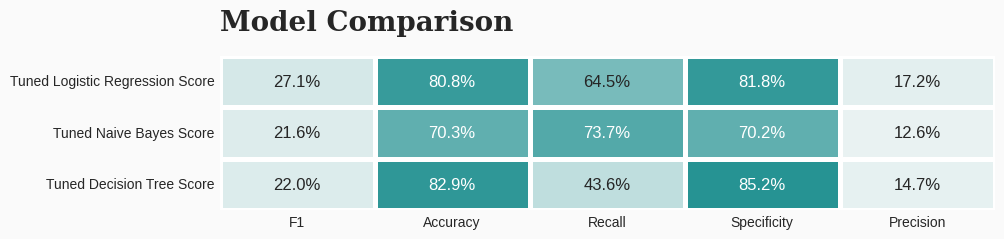

In [35]:
df_models = round(pd.concat([logreg_df, navbayes_df, dectree_df], axis=1), 3)
colors = [Colors.LightGray, Colors.LightCyan, Colors.Teal]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

fig = plt.figure(figsize=(10, 8), dpi=100, facecolor=Colors.LightGray)  # create figure
gs = fig.add_gridspec(3, 2, wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0:1, :])

sns.heatmap(
    df_models.T,
    cmap=colormap,
    annot=True,
    fmt=".1%",
    vmin=0,
    vmax=0.95,
    linewidths=2.5,
    cbar=False,
    ax=ax0,
    annot_kws={"fontsize": 12},
)
fig.patch.set_facecolor(Colors.LightGray)
ax0.set_facecolor(Colors.LightGray)
ax0.tick_params(axis="both", which="both", length=0)
ax0.text(
    0, -0.5, "Model Comparison", fontsize=20, fontweight="bold", fontfamily="serif"
)

fig.show()

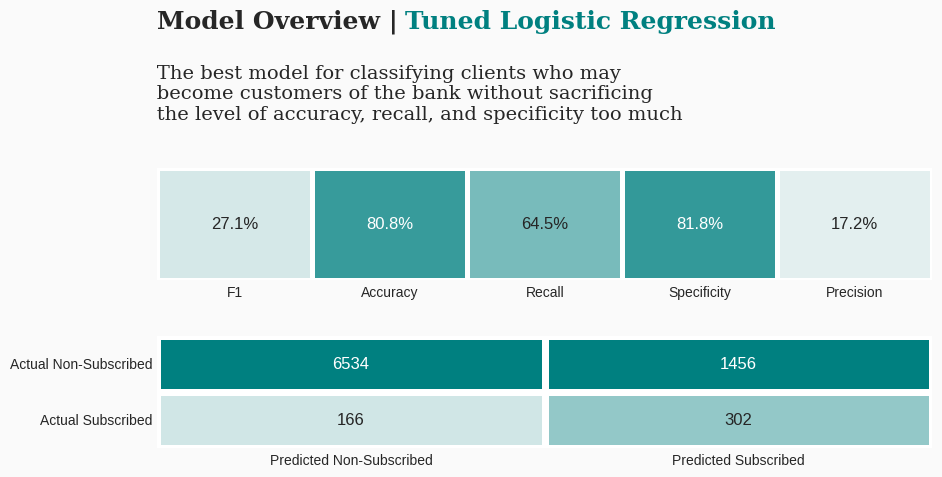

In [36]:
colors = [Colors.LightGray, Colors.LightCyan, Colors.Teal]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

fig = plt.figure(figsize=(10, 8), dpi=100, facecolor=Colors.LightGray)
gs = fig.add_gridspec(4, 2, wspace=0.1, hspace=0.5)

for ax in range(2):
    locals()["axis" + str(ax)] = fig.add_subplot(gs[ax, :])
    locals()["axis" + str(ax)].set_facecolor(Colors.LightGray)
    locals()["axis" + str(ax)].tick_params(axis="both", which="both", length=0)

sns.heatmap(
    logreg_df.T,
    cmap=colormap,
    annot=True,
    fmt=".1%",
    vmin=0,
    vmax=0.95,
    yticklabels="",
    linewidths=2.5,
    cbar=False,
    ax=axis0,
    annot_kws={"fontsize": 12},
)
sns.heatmap(
    logreg_cm,
    cmap=colormap,
    annot=True,
    fmt="d",
    linewidths=5,
    cbar=False,
    ax=axis1,
    yticklabels=["Actual Non-Subscribed", "Actual Subscribed"],
    vmax=500,
    vmin=0,
    xticklabels=["Predicted Non-Subscribed", "Predicted Subscribed"],
    annot_kws={"fontsize": 12},
)

axis0.text(
    0, -1.25, "Model Overview |", fontsize=18, fontweight="bold", fontfamily="serif"
)
axis0.text(
    1.6,
    -1.25,
    "Tuned Logistic Regression",
    fontsize=18,
    fontweight="bold",
    fontfamily="serif",
    color=Colors.Teal,
)
axis0.text(
    -0.45,
    -0.25,
    """
           The best model for classifying clients who may 
           become customers of the bank without sacrificing 
           the level of accuracy, recall, and specificity too much
           """,
    fontsize=14,
    fontweight="normal",
    fontfamily="serif",
)

fig.show()
